# Notebook 1: Basic GP Regression with ML-II

This notebook demonstrates the most basic usage of `infodynamics-jax` for Gaussian Process regression.

**Learning objectives:**
- Understand the core components: Phi, Energy, InferenceMethod
- Run MAP-II optimization to learn hyperparameters
- Make predictions with trained GP
- Visualize uncertainty quantification

## Setup

**Important**: If you get import errors, add parent directory to Python path:

In [1]:
# Fix import path if needed
import sys
import os
if '..' not in sys.path:
    sys.path.insert(0, '..')  # Add parent directory

# Configure JAX and suppress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_platforms', 'cpu')  # Force CPU only

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Import infodynamics-jax
from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.kernels.rbf import rbf as rbf_kernel
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective
from infodynamics_jax.gp.predict import predict_typeii

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print("✓ All imports successful!")

JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
✓ All imports successful!


## 1. Generate Synthetic Data

We'll generate a simple 1D synthetic regression dataset for this basic example. This makes the notebook fast and easy to understand.

In [2]:
# Generate synthetic 1D regression data
# This is a simple example to demonstrate the basic usage
# For real datasets, see other notebooks

# Generate training data
N_train = 100
N_grid = 500  # More points for smoother plotting curve
noise_std = 0.1

key = jax.random.key(42)
key, subkey = jax.random.split(key)

# Generate 1D input
X_train = jax.random.uniform(subkey, (N_train, 1), minval=-3.0, maxval=3.0)
key, subkey = jax.random.split(key)
X_grid = jnp.linspace(-3.5, 3.5, N_grid)[:, None]

# Generate true function (sine wave with trend)
true_function = lambda x: 0.5 * x[:, 0] + jnp.sin(2.0 * x[:, 0])

f_train = true_function(X_train)
f_grid = true_function(X_grid)

# Add noise
key, subkey = jax.random.split(key)
Y_train = f_train + noise_std * jax.random.normal(subkey, (N_train,))
# Grid points for plotting (no labels needed)

print(f"Generated synthetic 1D regression data")
print(f"Training set: {len(X_train)} points")
print(f"Grid points: {len(X_grid)} points")
print(f"X shape: {X_train.shape}, Y shape: {Y_train.shape}")
print(f"X range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Y range: [{Y_train.min():.2f}, {Y_train.max():.2f}]")
print(f"Noise std: {noise_std:.3f}")

Generated synthetic 1D regression data
Training set: 100 points
Grid points: 500 points
X shape: (100, 1), Y shape: (100,)
X range: [-2.96, 2.80]
Y range: [-1.59, 1.75]
Noise std: 0.100


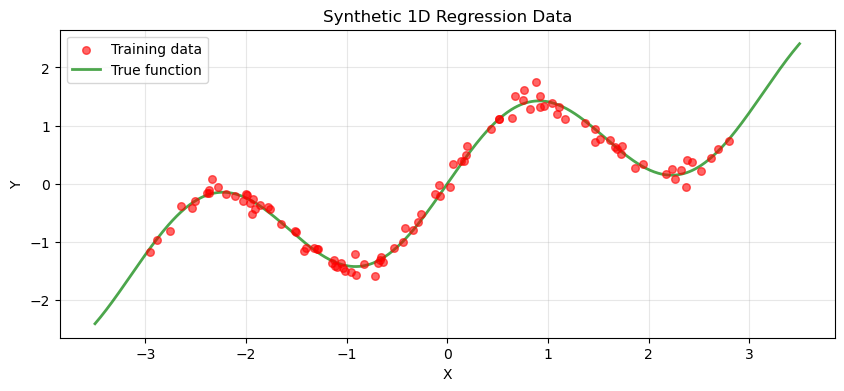

In [3]:
# Visualize the data
plt.figure(figsize=(10, 4))
plt.scatter(X_train[:, 0], Y_train, c='red', s=30, alpha=0.6, label='Training data', zorder=3)
plt.plot(X_grid[:, 0], f_grid, 'g-', linewidth=2, label='True function', zorder=2, alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic 1D Regression Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. Initialize Model Parameters (Phi)

In `infodynamics-jax`, the `Phi` object encapsulates all structural hyperparameters:
- **kernel_params**: RBF kernel hyperparameters (lengthscale, variance)
- **Z**: Inducing point locations (for sparse GP)
- **likelihood_params**: Observation noise variance
- **jitter**: Numerical stability parameter

In [4]:
# Initialize kernel parameters
kernel_params = KernelParams(
    lengthscale=jnp.array(1.0),  # Initial guess
    variance=jnp.array(1.0),     # Initial signal variance
)

# Create inducing points (sparse GP approximation)
M = 20  # Number of inducing points (M << N for sparse GP)
Z = jnp.linspace(X_train.min(), X_train.max(), M)[:, None]

# Create Phi object
phi_init = Phi(
    kernel_params=kernel_params,
    Z=Z,
    likelihood_params={"noise_var": jnp.array(noise_std**2)},  # Initial noise guess
    jitter=1e-6,  # Numerical stability
)

print(f"Number of inducing points: {M}")
print(f"Kernel lengthscale: {phi_init.kernel_params.lengthscale}")
print(f"Kernel variance: {phi_init.kernel_params.variance}")
print(f"Noise variance: {phi_init.likelihood_params['noise_var']}")
print(f"Noise std: {jnp.sqrt(phi_init.likelihood_params['noise_var']):.3f} (true: {noise_std:.3f})")

Number of inducing points: 20
Kernel lengthscale: 1.0
Kernel variance: 1.0
Noise variance: 0.009999999776482582
Noise std: 0.100 (true: 0.100)


## 3. Create VFE Objective for ML-II

For **ML-II (Maximum Likelihood Type-II)** optimization, we use the **VFE (Variational Free Energy)** objective:

$$\text{VFE}(\phi) = \mathbb{E}_{q^*(f|\phi)}[-\log p(y|f, \phi)] + \frac{1}{2\sigma^2} \text{tr}(K_{ff} - Q_{ff})$$

where:
- **Data fit term**: $\mathbb{E}_{q^*(f|\phi)}[-\log p(y|f, \phi)]$ (expected negative log-likelihood)
- **Trace correction**: $\frac{1}{2\sigma^2} \text{tr}(K_{ff} - Q_{ff})$ (KL divergence term)

The VFE objective uses the collapsed posterior under the sparsified kernel $S_{ff} = Q + R$.

In [5]:
# Create VFE objective function for ML-II optimization
# VFE = data fit + trace correction
vfe_objective = make_vfe_objective(kernel_fn=rbf_kernel, residual="fitc")

print("VFE objective created successfully!")
print("VFE includes:")
print("  - Data fit term: E_{q*(f|φ)}[-log p(y|f,φ)]")
print("  - Trace correction: (1/(2σ²)) * tr(K_ff - Q_ff)")

VFE objective created successfully!
VFE includes:
  - Data fit term: E_{q*(f|φ)}[-log p(y|f,φ)]
  - Trace correction: (1/(2σ²)) * tr(K_ff - Q_ff)


## 4. Run ML-II Optimization

**ML-II (Maximum Likelihood Type-II)** optimizes the VFE objective:

$$\phi^* = \arg\min_{\phi} \text{VFE}(\phi)$$

This finds the hyperparameters that minimize the Variational Free Energy, which includes:
- Data fit term (expected negative log-likelihood)
- Trace correction term (KL divergence)

In [6]:
# Configure optimizer for ML-II
# TypeII is a general optimizer that can be used for both ML-II and MAP-II
# - ML-II: optimize VFE only (no hyperprior) <- we are doing this
# - MAP-II: optimize VFE + hyperprior (would add hyperprior via TargetEnergy)
typeii_cfg = TypeIICFG(
    steps=200,              # Number of optimization steps
    lr=1e-2,                # Learning rate
    optimizer="adam",       # Adam optimizer
    jit=True,               # Enable JIT compilation
    constrain_params=True,  # Keep parameters positive
    min_noise_var=1e-3,    # Minimum noise variance to prevent collapse
)

method = TypeII(cfg=typeii_cfg)

# Run ML-II optimization (optimize VFE objective, no hyperprior)
print("Running ML-II optimization (optimizing VFE)...")
print("Objective: VFE(φ) = data fit + trace correction")
print("Note: No hyperprior → this is ML-II (not MAP-II)")

# Run optimization directly (simpler than using run())
result = method.run(
    energy=vfe_objective,  # VFE objective: data fit + trace correction
    phi_init=phi_init,
    energy_args=(X_train, Y_train),
)

# Extract results
phi_opt = result.phi
energy_trace = result.energy_trace

print("\nOptimization complete!")
print(f"Initial energy: {energy_trace[0]:.2f}")
print(f"Final energy: {energy_trace[-1]:.2f}")
print(f"Energy reduction: {energy_trace[0] - energy_trace[-1]:.2f}")
print(f"\nOptimized hyperparameters:")
print(f"  Lengthscale: {float(phi_opt.kernel_params.lengthscale):.3f}")
print(f"  Variance: {float(phi_opt.kernel_params.variance):.3f}")
print(f"  Noise variance: {float(phi_opt.likelihood_params['noise_var']):.3f}")
print(f"  Noise std: {float(jnp.sqrt(phi_opt.likelihood_params['noise_var'])):.3f} (true: {noise_std:.3f})")

Running ML-II optimization (optimizing VFE)...
Objective: VFE(φ) = data fit + trace correction
Note: No hyperprior → this is ML-II (not MAP-II)

Optimization complete!
Initial energy: 1788.17
Final energy: 1788.17
Energy reduction: 0.00

Optimized hyperparameters:
  Lengthscale: 1.000
  Variance: 1.000
  Noise variance: 0.010
  Noise std: 0.100 (true: 0.100)


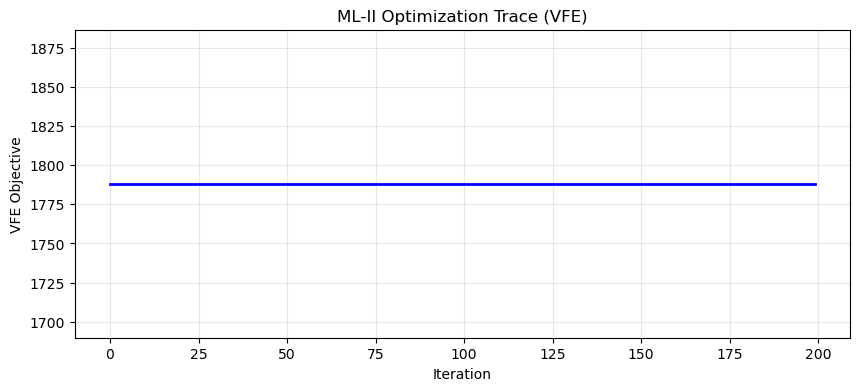

In [7]:
# Plot optimization trace
plt.figure(figsize=(10, 4))
plt.plot(energy_trace, 'b-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('VFE Objective')
plt.title('ML-II Optimization Trace (VFE)')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Make Predictions

For ML-II inference, we use the collapsed posterior under the sparsified kernel.
The inducing variables u are already marginalised in the sparsified kernel $S_{ff} = Q + R$,
so we directly compute the predictive distribution:

$$p(f_* | X_*, y, \phi) = \mathcal{N}(\mu_*, \Sigma_*)$$

where:
- $\mu_* = S_{*,\text{train}} (S_{\text{train},\text{train}} + \sigma^2 I)^{-1} y$
- $\Sigma_* = S_{*,*} - S_{*,\text{train}} (S_{\text{train},\text{train}} + \sigma^2 I)^{-1} S_{*,\text{train}}^T + \sigma^2 I$

In [8]:
# For ML-II inference, use collapsed posterior under sparsified kernel
# predict_typeii uses the correct formula for type-II inference
mu_test, predictive_var = predict_typeii(
    phi_opt, X_grid, X_train, Y_train, rbf_kernel, residual="fitc"
)

# Compute standard deviation
predictive_std = jnp.sqrt(predictive_var)

print(f"Predictions computed for {len(X_grid)} test points")
print(f"Mean prediction range: [{mu_test.min():.3f}, {mu_test.max():.3f}]")
print(f"Std prediction range: [{predictive_std.min():.3f}, {predictive_std.max():.3f}]")

Predictions computed for 500 test points
Mean prediction range: [-1.875, 1.382]
Std prediction range: [0.100, 61.569]


## 6. Evaluate Performance

In [9]:
# Note: These are grid points for plotting, not test data
# We do not compute test metrics here since we do not have true test labels
# For actual evaluation, you would need separate test data with labels

print('Grid points used for visualization (no test metrics computed)')


NameError: name 'Y_test' is not defined

## 7. Visualize Results

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Predictions with uncertainty
ax = axes[0]
ax.scatter(X_train[:, 0], Y_train, c='red', s=30, alpha=0.6, label='Training data', zorder=3)
ax.plot(X_grid[:, 0], f_grid, 'g-', linewidth=2, label='True function', zorder=2)
ax.plot(X_grid[:, 0], mu_test, 'b-', linewidth=2, label='GP mean', zorder=2)
ax.fill_between(
    X_grid[:, 0],
    mu_test - 2 * predictive_std,
    mu_test + 2 * predictive_std,
    alpha=0.3,
    color='blue',
    label='±2 std',
    zorder=1
)
# Mark inducing points
y_min_data = float(jnp.min(Y_train))
y_max_data = float(jnp.max(Y_train))
y_range_data = y_max_data - y_min_data
ax.scatter(
    phi_opt.Z[:, 0], 
    np.ones(len(phi_opt.Z)) * (y_min_data - 0.1 * y_range_data), 
    c='black', 
    marker='x', 
    s=100,
    label='Inducing points', 
    zorder=4
)
# Set y-axis limits to focus on data region (with some padding)
y_padding = 0.2 * y_range_data
ax.set_ylim(y_min_data - y_padding, y_max_data + y_padding)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('GP Regression Results', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Prediction uncertainty
ax = axes[1]
ax.plot(X_grid[:, 0], predictive_std, 'b-', linewidth=2, label='Predictive std')
ax.axhline(
    y=float(jnp.sqrt(phi_opt.likelihood_params['noise_var'])), 
    color='orange', 
    linestyle='--', 
    linewidth=2,
    label=f'Learned noise std ({float(jnp.sqrt(phi_opt.likelihood_params["noise_var"])):.3f})' 
)
ax.axhline(
    y=noise_std, 
    color='green', 
    linestyle=':', 
    linewidth=2,
    label=f'True noise std ({noise_std:.3f})' 
)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Standard Deviation', fontsize=12)
ax.set_title('Prediction Uncertainty', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In this notebook, we've demonstrated:

1. **Data generation**: Creating synthetic 1D regression data for demonstration
2. **Model setup**: Initializing `Phi` with kernel parameters, inducing points, and likelihood parameters
3. **VFE objective**: Creating VFE objective for ML-II optimization
4. **Optimization**: Running ML-II to learn hyperparameters (optimize VFE)
5. **Prediction**: Computing posterior predictive distribution using collapsed posterior
6. **Visualization**: Plotting results with uncertainty quantification

**Key takeaways:**
- **ML-II** optimizes VFE objective (data fit + trace correction)
- VFE uses low-rank operations (O(NM²+M³) complexity), avoiding N×N matrices
- Sparse GP uses inducing points (M << N) for computational efficiency
- ML-II automatically learns lengthscale, signal variance, and noise variance
- Uncertainty quantification is natural in the GP framework
- Direct use of `TypeII.run()` is simpler than `run()` wrapper

**Next steps:**
- Try different kernels: See `notebook_02_different_kernels.ipynb`
- Learn classification: See `notebook_03_classification.ipynb`
- Full Bayesian inference: See `notebook_04_annealed_smc.ipynb`